In [1]:
# will calculate necessary boutique flow fields for main figure, and incongruent trial block probabilities,
import pickle, json
import numpy as np
from scipy.special import softmax

import matplotlib.pyplot as plt


from dynamics.process.rnn import wt_protocols
from dynamics.process.rnn import parse
from dynamics.analysis import KEmin, flowfields, posttraining
import dynamics.analysis.dynamics_analysis as dyn
from dynamics.utils import utils


%load_ext autoreload
%autoreload 2

dbase = '/Users/dhocker/projects/dynamics/results/20231003/'
codedir = '/Users/dhocker/projects/dynamics/'

num_rnns = {0:50, 1:50, 2:20, 3:10, 4:10, 5:10, 6:10, 7:10, 8:10}  # number of RNNs per training type, by sidx

In [4]:
#decide OFC or STR
useOFC = True

if useOFC:
    # for OFC
    num = 33
    stype = 'full_cl/'
    reg_idx = 0
    blocklist = ['mixed']  # block type does not change flowfield for OFC
    
else:
    # for STR
    num = 23
    stype = 'full_cl/'
    reg_idx = 1
    blocklist = ['mixed','high','low']  # do flowfield with inputs from characteric inputs of block type

s_idx = 0
t_idx = 5
epoch = 'wait'
useKEbounds = True
D = 2  # dimensionality of flowfield
    
d = utils.getfnames(num, s_idx, t_idx, 10, dbase=dbase,
              reg_idx=reg_idx, block='mixed', epoch='wait')

# load data, set up params for each region (STR or OFC)
basedirectory = codedir+'dynamics/analysis/'
# savedir_flows = d['flow'].split('flowfield')[0]  # where flowfield will be saved. ORIGINAL DATA SAVED HERE. 
savedir_flows = dbase + 'test/'  # where flowfield will be saved
savedir = d['dat'].split('rnn_curric')[0]  # where 1k data is stored
savedir_KE = d['ke'].split('kemin')[0]  # where KE dat is stored. needed for setting PC bounds to capture features
modelname = d['model']
dataname = d['dat_1k']  # 1k trials of data where the neural activity is stored



In [ ]:

#loop over each potential type of block input
for blocktype in blocklist:
    print(blocktype)

    d = utils.getfnames(num, s_idx, t_idx, 10, dbase=dbase,
              reg_idx=reg_idx, block=blocktype, epoch=epoch)
    kemin_name = d['ke']

    #flowfield options
    fo = {'reg_idx': reg_idx, 's_idx': s_idx, 'tphase': t_idx, 'epoch': epoch, 'blocktype': blocktype,
          'verbose': True, 'useKEbounds': useKEbounds, 'basedirectory': basedirectory,
          'savedir': savedir_flows}  # flowops dictionary
    
    if useKEbounds:
        flowname = savedir_flows + d['flow_boutique'].split('/')[-1]
    else:
        flowname = savedir_flows + d['flow'].split('/')[-1]
        
        
    print(flowname)
 
    test = flowfields.genflowfields(modelname, dataname, kemin_name, flowname, fo, D=D, block_idx = None)





In [6]:
# figure B and supp data. preprocess data as if to do dynamics, then extract block transition sequences

# load data
dataname = savedir + 'rnn_curric_33_block_10_1k.json'
modelname = savedir +'rnn_curric_33_block_10.model'

with open(dataname,'r') as f:
    jsondat = json.load(f)

dat = parse.json2dat(jsondat)


fo = {'reg_idx': 0, 's_idx': 0, 'tphase': 5, 'epoch': 'wait', 'blocktype': 'mixed',
      'verbose': True, 'useKEbounds': False,
      'basedirectory': basedirectory,
      'savedir': None} 

dynops = {'numhidden': [256, 256], 'resim': False, 'configname': basedirectory+'block.cfg', 'epoch': 'wait',
              'zeromean': False, 'block_idx': None}

rd = dyn.dynamics_preprocess_suite(modelname, dat, simtype='task', dynops=dynops)

uniqueops: adam_fname not defined in config. using default
postprocessing simulation data for dynamics
epoch wait
building trial masks and getting conditional PSTHs


/Users/dhocker/projects/dynamics/dynamics/process/rnn/parse_state.py:159: RuntimeWarning: Mean of empty slice
  psth_ofc_h[m, :, :] = np.nanmean(psth_ofc_h_base, axis=0)
/Users/dhocker/projects/dynamics/dynamics/process/rnn/parse_state.py:160: RuntimeWarning: Mean of empty slice
  psth_ofc_c[m, :, :] = np.nanmean(psth_ofc_c_base, axis=0)
/Users/dhocker/projects/dynamics/dynamics/process/rnn/parse_state.py:161: RuntimeWarning: Mean of empty slice
  psth_str_h[m, :, :] = np.nanmean(psth_str_h_base, axis=0)
/Users/dhocker/projects/dynamics/dynamics/process/rnn/parse_state.py:162: RuntimeWarning: Mean of empty slice
  psth_str_c[m, :, :] = np.nanmean(psth_str_c_base, axis=0)
/Users/dhocker/miniconda3/envs/torchenv/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Dim
3
3


In [7]:
# find incongruent trials
reg_idx = 0

#flatten state, pred, and get trial times
sflat, inp, tdict = parse.get_trialtimes(dat)
predflat = []
for j in dat['preds']:
    predflat.extend(j)
    
sflat_ofc = []
sflat_str = []
for sj in sflat:
    sflat_ofc_j = np.squeeze(np.concatenate((np.expand_dims(sj[0,0,:],axis=1),
                                             np.expand_dims(sj[0,1,:],axis=1)),axis=0))
    sflat_str_j = np.squeeze(np.concatenate((np.expand_dims(sj[1,0,:],axis=1),
                                             np.expand_dims(sj[1,1,:],axis=1)),axis=0))
    
    sflat_ofc.append(sflat_ofc_j)
    sflat_str.append(sflat_str_j)   
    
if reg_idx == 0:    
    pca_use = rd['pca_ofc']
    sflat_use = np.array(sflat_ofc)
else:
    pca_use = rd['pca_ofc']
    sflat_use = np.array(sflat_str)
    
    
# find incongruent trials at block transitions
blocks = dat['blocks']
preds_start = np.array([predflat[j] for j in tdict['start']])
offers = dat['rewvols']
pblock = np.array([softmax(j) for j in predflat])
outcomes = dat['outcomes']

#find block transitions
test = np.argwhere(np.diff(blocks)!= 0)

#the located transition points in this data. can examine them with pblock, outcomes, blocks, offers, etc.
idx_h2m = 165
idx_m2h = 123
idx_m2l = 373  # 39, 207, 373
idx_l2m = 80

blocks[idx_m2l:idx_m2l+2]

array([0, 2])

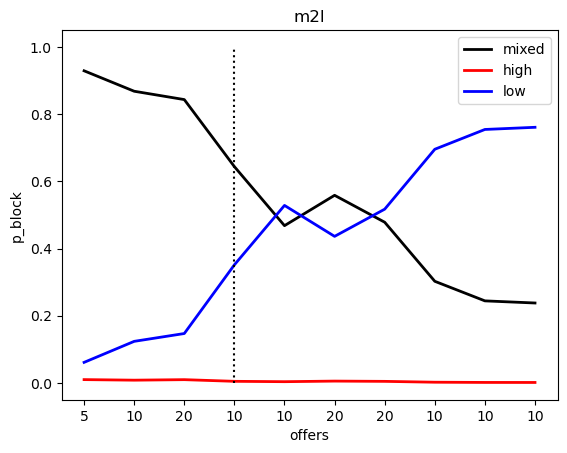

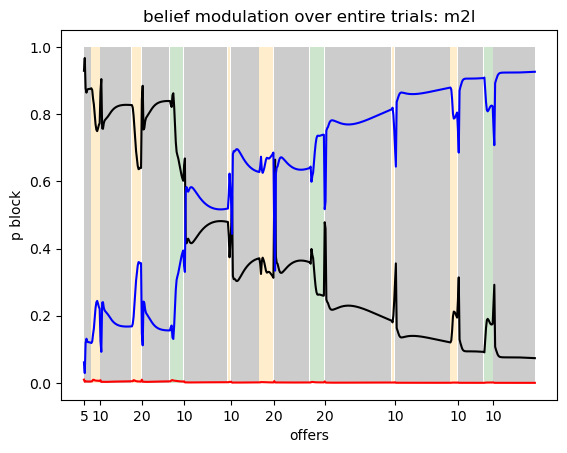

In [10]:
#Fig 4B and supp:  set transition type and make figure 

transtype = 'm2l'

if transtype == 'm2h': # mixed to high transition (supp)
    trans_idx = [idx_m2h-1, idx_m2h+1, idx_m2h+6]
elif transtype == 'h2m': # high to mixed transition (supp)
    trans_idx = [163, 167, 175] #pre-incongruent, incongruent, congruent
elif transtype == 'l2m': # low to mixed transition (supp)
    trans_idx = [idx_l2m-1, idx_l2m+2, idx_l2m+4]
elif transtype == 'm2l': # mixed to low transition (main fiure)
    trans_idx = [idx_m2l-2, idx_m2l+1, idx_m2l+7]
else:
    print('issue with transtype')
    
#show the change in beliefs at a block transition you found:
#trying to figure out the predicted pblock values on my trials of interest
idx_precon = trans_idx[0]
idx_incon = trans_idx[1]
idx_con = trans_idx[2]

tdict = rd['behdict']['tdict']
preds = rd['behdict']['preds']
preds_flat = []
for k in preds:
    preds_flat.extend(k)
    
offers = rd['behdict']['offers'][idx_precon:idx_con+1]

logpvals = np.array([preds[tdict['start'][k]] for k in range(idx_precon, idx_con+1)])
pvals = softmax(logpvals,axis=1)

tvec = range(-3,len(range(idx_precon,idx_con))-2)
plt.plot(tvec,pvals[:,0],linewidth=2, color='k',label='mixed')
plt.plot(tvec,pvals[:,1],linewidth=2, color='red',label='high')
plt.plot(tvec,pvals[:,2],linewidth=2, color='blue',label='low')

plt.vlines(0,0,1,color='k',linestyle='dotted')
plt.xticks(tvec,np.exp(offers).astype(int))

plt.legend()
plt.title(transtype)
plt.xlabel('offers')
plt.ylabel('p_block')
plt.show()

#---------=

tstarts = np.array(tdict['start'][idx_precon:idx_con+1])-tdict['start'][idx_precon]
titi = np.array(tdict['iti'][idx_precon:idx_con+1])-tdict['start'][idx_precon]
outcomes_testdat = outcomes[idx_precon:idx_con+1]

for j in range(len(tstarts)):
    plt.fill_between(range(tstarts[j],titi[j]),0,1,color = 'k',alpha = 0.2, linewidth=0.0)
    
for j in range(len(tstarts)-1):
    if outcomes_testdat[j] == 1:
        plt.fill_between(range(titi[j],tstarts[j+1]),0,1,color = 'g',alpha = 0.2, linewidth=0)
    elif outcomes_testdat[j] == 0:
        plt.fill_between(range(titi[j],tstarts[j+1]),0,1,color = 'orange',alpha = 0.2, linewidth=0)

plt.plot(pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],0],color='k')
plt.plot(pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],1],color='r')
plt.plot(pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],2],color='b')

plt.ylabel('p block')
plt.xlabel('timesteps')
plt.xticks(tstarts,np.exp(offers).astype(int))
plt.xlabel('offers')


pmixdat = pblock[tdict['start'][idx_precon]:tdict['iti'][idx_con],0]

plt.title('belief modulation over entire trials: ' + transtype)

plt.show()
